In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [2]:
%run srcnn.py

In [3]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9426852602680786699
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3674341376
locality {
  bus_id: 1
}
incarnation: 12132628301587230816
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


### Load images

In [6]:
PATH = ""
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
TEST_FILE = PATH +"datasets/DIV2K_train_LR_wild/"
VALID_HR = PATH +"datasets/DIV2K_valid_HR/"
VALID_LR = PATH +"datasets/DIV2K_valid_LR_wild/"
obj_files = listdir(TRAIN_FILE )
valid_files = listdir(VALID_HR )

In [7]:
valid_files[:5]

['0844.png', '0881.png', '0873.png', '0878.png', '0813.png']

In [8]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [9]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,64): #should be replaced here with something random at some point
    n = obj_files[i]
    m = valid_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    train_img.append(Image.open(TEST_FILE + n[:-4]+"x4w1.png"))
    
    valid_hr_img.append(Image.open(VALID_HR +  m))
    valid_lr_img.append(Image.open(VALID_LR + m[:-4]+"x4w.png"))
#Only consider the luminance channel (YCrCb)
ycbcr_obj = convertToYCbCr(obj_img)
ycbcr_train = convertToYCbCr(train_img)
ycbr_valid_hr = convertToYCbCr(valid_hr_img)
ycbr_valid_lr = convertToYCbCr(valid_lr_img)

In [10]:
ycbcr_obj[0].size

(2040, 1356)

In [11]:
#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [12]:
#Convert images to numpy array
imgs_label = [np.asarray(image)[:,:,0] for image in ycbcr_obj]
imgs_train = [np.asarray(image)[:,:,0] for image in ycbcr_train]
imgs_valid_hr = [np.asarray(image)[:,:,0] for image in ycbr_valid_hr]
imgs_valid_lr = [np.asarray(image)[:,:,0] for image in ycbr_valid_lr]


In [13]:
imgs_label[0].shape

(1356, 2040)

(1356, 2040)


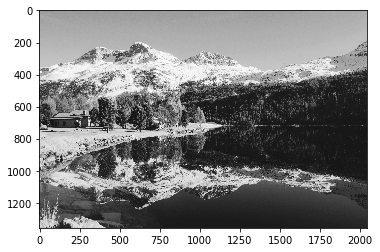

In [14]:
print(imgs_label[1].shape)
print_luminance(imgs_label[1])

(339, 510)


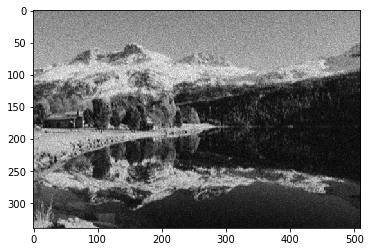

In [15]:
print(imgs_train[1].shape)
print_luminance(imgs_train[1])

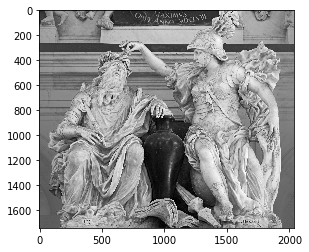

In [16]:
print_luminance(imgs_valid_hr[3])

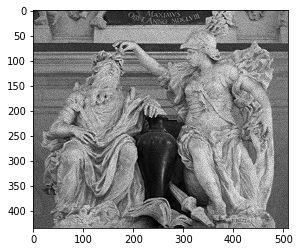

In [17]:
print_luminance(imgs_valid_lr[3])

### Generate train and test set

In [18]:
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]

In [19]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [20]:
#Division by 4
window_size= 32
scale = 4
stride = 32
subimages_per_axis = 4

In [21]:
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

In [22]:
sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

for i in range(0,50) :
    label = imgs_label[i]
    shape = imgs_train[i].shape
    s = cv2.resize(imgs_train[i], dsize = (shape[1]*4, shape[0]*4), interpolation = cv2.INTER_CUBIC)
    
    valid_hr = imgs_valid_hr[i]
    shape_lr = imgs_valid_lr[i].shape
    valid_lr = cv2.resize(imgs_valid_lr[i], dsize = (shape_lr[1]*4, shape_lr[0]*4), interpolation = cv2.INTER_CUBIC)
    
    #height_label, width_label = retSize(label)
    #height_sample, width_sample = retSize(s)
    #height_hr, width_hr = retSize(valid_hr)
    #height_vlr, width_vlr = retSize(valid_lr)
    
    #len_interval = height_sample//subimages_per_axis
    
    #Calculate subimages
    sub_labels += getSubImages(label)
    sub_samples += getSubImages(s)
    sub_valid_hr += getSubImages(valid_hr)
    sub_valid_lr += getSubImages(valid_lr)

In [23]:
len(sub_labels)

38862

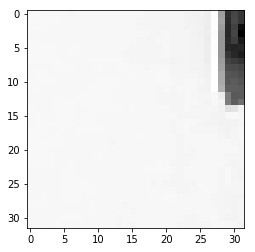

In [24]:
print_luminance(sub_labels[400])

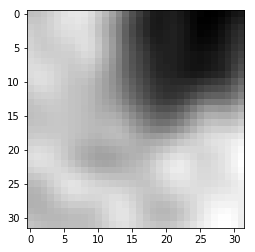

In [25]:
print_luminance(sub_samples[400])
#sub_samples[1].shape

(32, 32)

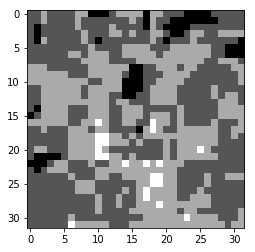

In [26]:
print_luminance(sub_valid_hr[7])
sub_valid_hr[1].shape

(32, 32)

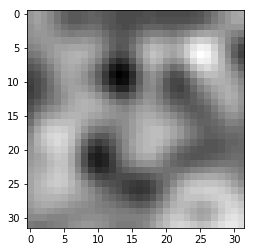

In [27]:
print_luminance(sub_valid_lr[7])
sub_valid_lr[1].shape

#### Generate the wavelets subbands

In [28]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [29]:
def plot4images(im1, im2, im3, im4, ch=1) :
    fig = plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    plt.title("Average")
    print_luminance(im1, ch )
    plt.subplot(222)
    print_luminance(im2, ch)
    plt.subplot(223)
    print_luminance(im3, ch)
    plt.subplot(224)
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)

(16, 16)


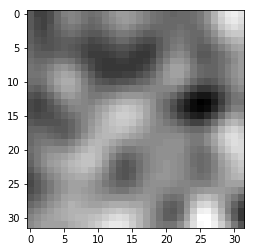

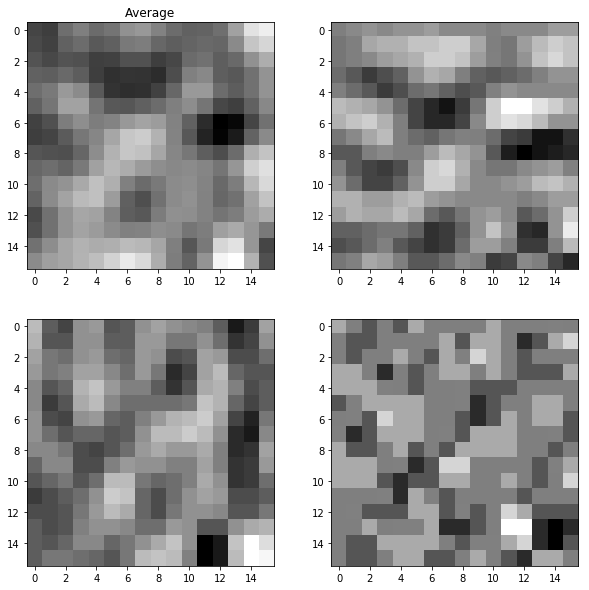

In [30]:
x_sample = sub_samples[1]
print_luminance(x_sample)
x_dwt = pywt.dwt2(x_sample, 'haar')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

273.0


numpy.ndarray

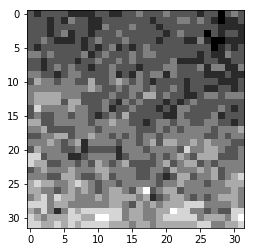

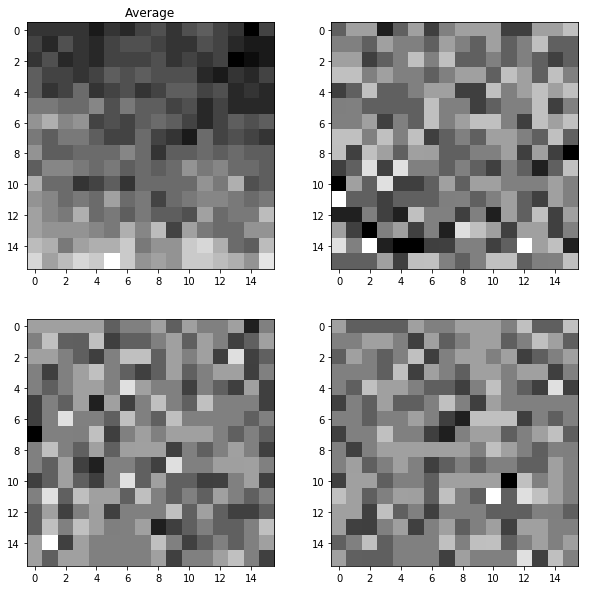

In [31]:
y_sample = sub_labels[1]
print_luminance(y_sample)
y_dwt = pywt.dwt2(y_sample, 'haar')
print(y_dwt[0].max())
plot_waveletTrans(y_dwt)
type(y_dwt[1][1])

In [32]:
pepe = np.asfarray([y_dwt[0], y_dwt[1][0], y_dwt[1][1], y_dwt[1][2]])
pepe.max()

273.00000000000006

In [33]:
shape = 32

test_list = []
train_list = []
for i in range(len(sub_labels)):
    y = sub_labels[i]
    x = sub_samples[i]
    vy = sub_valid_hr[i]
    vx = sub_valid_lr[i]
    
    dwt_y = pywt.dwt2(y, 'haar')
    dwt_x = pywt.dwt2(x, 'haar')    
    
    
    hight = np.asfarray([dwt_y[0], dwt_y[1][0], dwt_y[1][1], dwt_y[1][2]])
    x = np.asfarray([dwt_x[0], dwt_x[1][0], dwt_x[1][1], dwt_x[1][2]])
    
    y = hight - x
    
    test_list.append(y)
    train_list.append(x)

In [34]:
t = test_list[10] == train_list[10]

In [35]:
def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.50
    

In [36]:
len(test_list)

38862

In [37]:
max_ = 0
for i in range(len(test_list)) :
    tmp = test_list[i].max()
    if (tmp > max_ ) :
        max_ = tmp
max_

503.50000000000006

In [38]:
test = np.asarray(test_list)
train = np.asarray(train_list)

#print(test.max())

#test = test / 255.
#train = test / 255.

In [39]:
equals(test_list[0], train_list[0])

True

In [40]:
test.shape

(38862, 4, 16, 16)

In [41]:
equals(train[10], test[10])

True

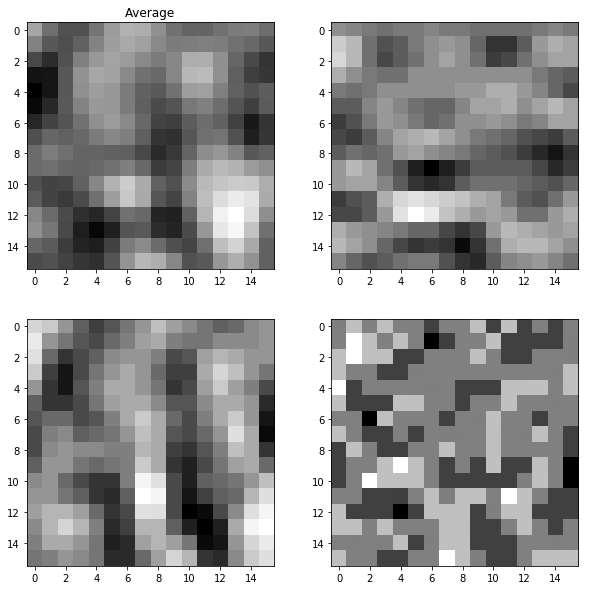

In [42]:
sample = train[10]
plot4images(sample[0], sample[1], sample[2], sample[3])

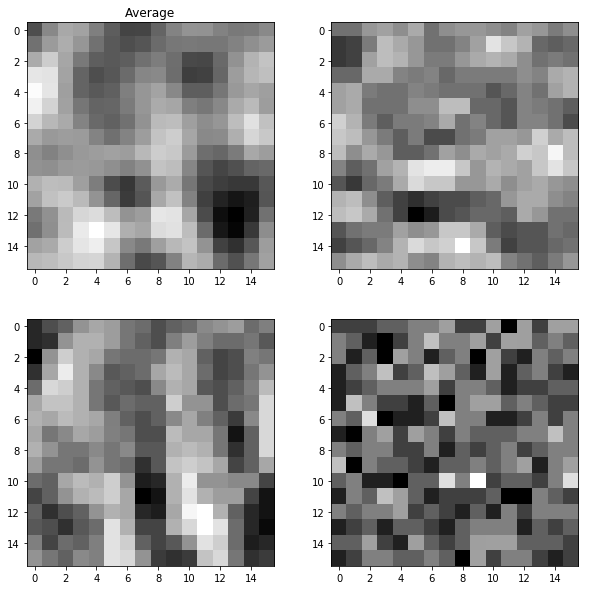

In [43]:
label = test[10]
plot4images(label[0], label[1], label[2], label[3])

#### Creating and Training the networks

In [44]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [45]:
input_shape = train.shape
input_shape
shape_ = (input_shape[1],input_shape[2], input_shape[3])

In [46]:
window_size

32

In [47]:
kernel_ini = initializers.RandomNormal(mean=0.0, stddev=1e-3, seed=None)
bias_ini = keras.initializers.Zeros()

adam = optimizers.Adam() 

In [48]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='selu',
                 input_shape=shape_,
                 kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini,
                 data_format='channels_first'))
for i in range(10) :
    model.add(Conv2D(64, (3, 3),strides=(1,1), activation='selu', padding='same', kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini, data_format='channels_first'))

    
model.add(Conv2D(4, (3, 3),strides=(1,1), padding='same', kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini, data_format='channels_first'))

model.compile(optimizer=Adam(),
             loss='mean_absolute_error')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 16, 16)        6464      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 16, 16)        36928     
__________

In [49]:
history_CNN = model.fit(train, test, validation_split=0.2, epochs=5, batch_size=64, verbose=1)

Train on 31089 samples, validate on 7773 samples
Epoch 1/5
31089/31089 [==============================] - 21s 683us/step - loss: 14.4657 - val_loss: 11.3264
Epoch 2/5
31089/31089 [==============================] - 20s 653us/step - loss: 14.0280 - val_loss: 10.9361
Epoch 3/5
31089/31089 [==============================] - 20s 652us/step - loss: 13.4291 - val_loss: 10.8129
Epoch 4/5
31089/31089 [==============================] - 20s 659us/step - loss: 13.2164 - val_loss: 10.8778
Epoch 5/5
31089/31089 [==============================] - 21s 666us/step - loss: 13.1743 - val_loss: 10.7110


In [81]:
save_model(model, "SRCNN_deep")

#### Original image and bicubic interpolated image

In [71]:
def patch_to_image(patches, height, width) :
    count = 0
    window_size =32
    img = np.zeros((height, width))
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            img[h : h + window_size, w : w + window_size] = patches[count]
            count = count + 1
    return img

In [72]:
PRED_FILE = PATH + "datasets/DIV2K_test_LR_wild/0901x4w.png"
im = Image.open(PRED_FILE)

img = np.asarray(im.convert('YCbCr'))
img = img[:,:,0]
img.shape
h, w = retSize(img)
img.shape
#img = np.asarray(convertToYCbCr([im]))

(339, 510)

In [73]:
sub_img = getSubImages(img)

t.shape

(4, 16, 16)

In [74]:
pred_list = []
for i in range(len(sub_img)):
    wavlets = sub_img[i]
    
    dwt_w = pywt.dwt2(wavlets, 'haar')
    
    low = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])
    
    pred_list.append(low)


In [75]:
pred_imgs = np.asarray(pred_list)
pred_imgs.shape

(48, 4, 16, 16)

In [76]:
wv = model.predict(pred_imgs)

In [68]:
im = wv + pred_imgs
print(im[1].shape)
rec_img = []
for i in range(len(im)) :
    patch = im[i]
    dwt = (patch[0], (patch[1], patch[2], patch[3]))
    rec = pywt.idwt2(dwt, 'haar')
    rec_img.append(rec)

(4, 16, 16)


In [69]:
rec_img[0].shape

(32, 32)

In [79]:
im = patch_to_image(rec_img, h, w)

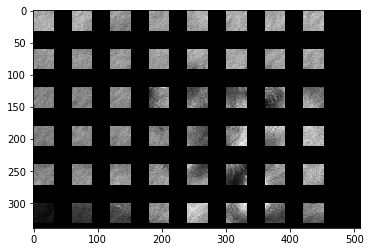

In [80]:
print_luminance(im)

In [63]:
print_luminance(it)

NameError: name 'it' is not defined

In [ ]:
save_model(model, "test")